In [70]:
# House Price Problem
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,Normalizer,RobustScaler
from sklearn.linear_model import LinearRegression,LassoCV,Ridge,LassoLarsCV,ElasticNetCV 
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve,train_test_split,KFold
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import catboost as cat

from scipy import stats
import warnings
import datetime as dt

%matplotlib notebook
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #'last' 기본값

## 1. 데이터 가져오기
- 데이터 로딩(train, test)
- 데이터 확인
- 이상값 제거

In [2]:
# 데이터 가져오기
train_path = "./data/train.csv"
test_path = "./data/test.csv"

In [3]:
origin_train = pd.read_csv(train_path)
origin_test = pd.read_csv(test_path)

In [4]:
origin_train.shape

(1460, 81)

In [5]:
origin_train.head()
origin_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# feature 분리 : category - 43
origin_train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [7]:
# feature 분리 : numerical - 38
origin_train.select_dtypes(exclude=['object']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

- 숫자형 변수 중 범주형 변수로 취급되어야 할 설명변수가 있음(년도)
: YearBuilt, YearRemodAdd, MoSold, YrSold, MSSubClass

In [8]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

In [9]:
# Id는 분석할때 필요 없음
df_train = origin_train.drop(labels=["Id"], axis=1)
df_test = origin_test.drop(labels=["Id"], axis=1)

In [10]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


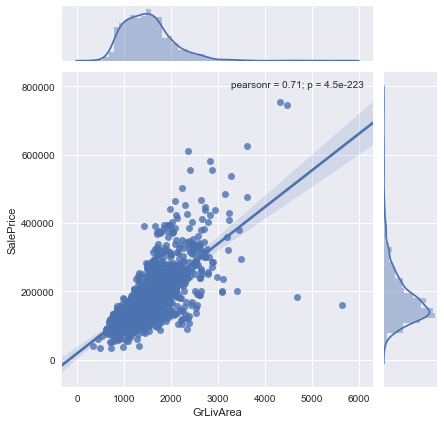

In [11]:
# 이상값 제거 전
g = sns.jointplot(x = df_train['GrLivArea'], y=df_train['SalePrice'], kind="reg")

In [12]:
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & 
                         (df_train['SalePrice'] < 300000)].index).reset_index(drop=True)

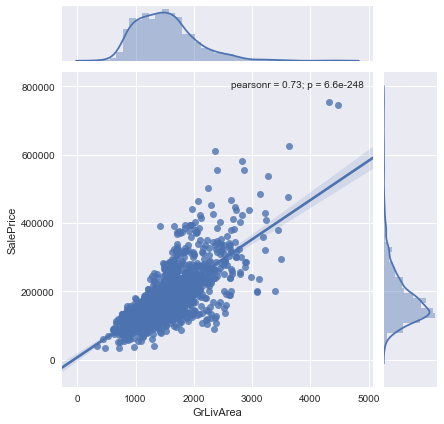

In [13]:
# 이상값 제거 후
g = sns.jointplot(x = df_train['GrLivArea'], y=df_train['SalePrice'], kind="reg")

## 2. 결과변수(SalesPrice) 분석

In [14]:
df_train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

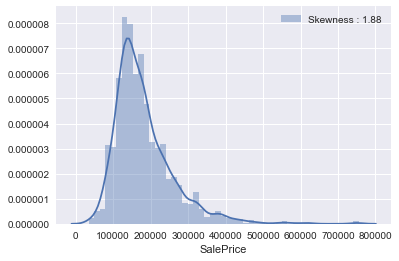

In [15]:
# ploting
g = sns.distplot(df_train['SalePrice'])
g = g.legend(['Skewness : {:.2f}'.format(df_train['SalePrice'].skew())],loc='best')

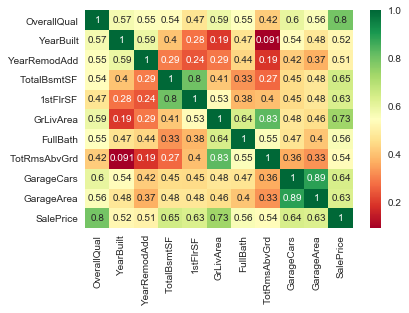

In [16]:
# correlation feature
corrmat = df_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"]) > 0.5]
g = sns.heatmap(df_train[top_corr_features].corr(), annot=True, cmap='RdYlGn')

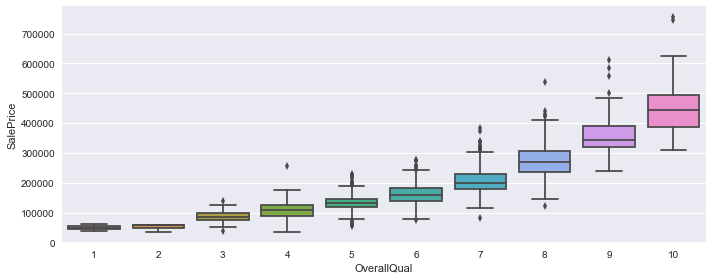

In [17]:
# top features 분석 : OverallQual, GriLivArea, TotalBsmtSF, GarageCar, GarageArea 
# 1. OverallQual
x_var = "OverallQual"
y_var = "SalePrice"
g = sns.factorplot(x=x_var, y=y_var, data=df_train, kind='box', aspect=2.5)

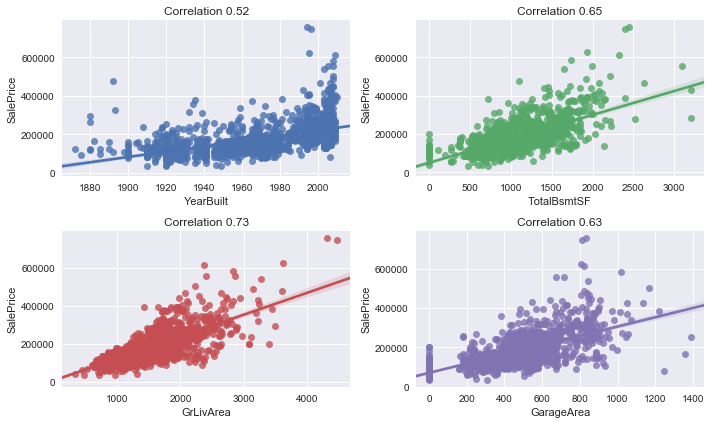

In [18]:
# 2. GriLivArea, TotalBsmtSF, GarageCar, GarageArea , YearBulit,"DiffYear","YrSold"
feats = ["YearBuilt","TotalBsmtSF","GrLivArea","GarageArea"]
multiplot(data=df_train, features=feats, plottype="regplot",nrows=2, ncols=2, figsize=(10,6), y="SalePrice", colorize=True)

## 3. 결측값 분석
- 3.1: 결측값을 어떻게 채울 것인가?

In [19]:
df_train_len = len(df_train)
dataset = pd.concat(objs=[df_train,df_test], axis=0).reset_index(drop=True)

In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 80 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            198 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2835 non-null object
BsmtExposure     2835 non-null object
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtFinType1     2838 non-null object
BsmtFinType2     2837 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2836 non-null object
BsmtUnfSF        2916 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2916 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      291

In [21]:
dataset = dataset.fillna(np.nan)

In [22]:
missing_features = dataset.columns[dataset.isnull().any()]
missing_features

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF',
       'Utilities'],
      dtype='object')

In [23]:
dataset[missing_features].isnull().sum()

Alley           2719
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2346
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2812
PoolQC          2908
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [24]:
per_missing_features = (dataset[missing_features].isnull().sum() 
                        / dataset[missing_features].isnull().count()).sort_values(ascending=False)
per_missing_features

PoolQC          0.996915
MiscFeature     0.964004
Alley           0.932122
Fence           0.804251
SalePrice       0.500171
FireplaceQu     0.486802
LotFrontage     0.166610
GarageQual      0.054508
GarageCond      0.054508
GarageFinish    0.054508
GarageYrBlt     0.054508
GarageType      0.053822
BsmtExposure    0.028111
BsmtCond        0.028111
BsmtQual        0.027768
BsmtFinType2    0.027425
BsmtFinType1    0.027083
MasVnrType      0.008228
MasVnrArea      0.007885
MSZoning        0.001371
BsmtFullBath    0.000686
BsmtHalfBath    0.000686
Utilities       0.000686
Functional      0.000686
Electrical      0.000343
BsmtUnfSF       0.000343
Exterior1st     0.000343
Exterior2nd     0.000343
TotalBsmtSF     0.000343
GarageCars      0.000343
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
KitchenQual     0.000343
SaleType        0.000343
GarageArea      0.000343
dtype: float64

In [25]:
# 결측값 처리 
dataset["Alley"] = dataset["Alley"].fillna("No")
dataset["MiscFeature"] = dataset["MiscFeature"].fillna("No")
dataset["Fence"] = dataset["Fence"].fillna("No")
dataset["PoolQC"] = dataset["PoolQC"].fillna("No")
dataset["FireplaceQu"] = dataset["FireplaceQu"].fillna("No")

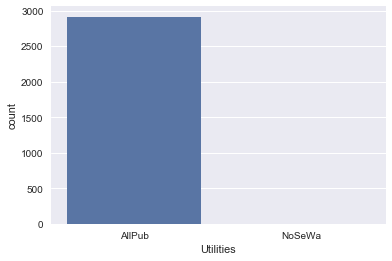

In [26]:
g = sns.countplot(dataset["Utilities"])

In [27]:
# 남은 na값을 한쪽으로 채워줌.
dataset["Utilities"] = dataset["Utilities"].fillna("AllPub")

In [28]:
# 각 특성에 따른 결측값들 세팅?
dataset["BsmtCond"] = dataset["BsmtCond"].fillna("No")
dataset["BsmtQual"] = dataset["BsmtQual"].fillna("No")
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].fillna("No")
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].fillna("No")

dataset.loc[dataset["BsmtCond"]=="No", "BsmtUnfSF"] = 0
dataset.loc[dataset["BsmtFinType1"]=="No", "BsmtFinSF1"] = 0
dataset.loc[dataset["BsmtFinType2"]=="No", "BsmtFinSF2"] = 0
dataset.loc[dataset["BsmtQual"]=="No", "TotalBsmtSF"] = 0
dataset.loc[dataset["BsmtCond"]=="No", "BsmtFullBath"] = 0
dataset.loc[dataset["BsmtCond"]=="No", "BsmtHalfBath"] = 0
dataset["BsmtExposure"] = dataset["BsmtExposure"].fillna("No")

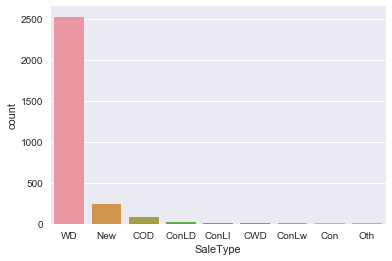

In [29]:
g = sns.countplot(dataset["SaleType"])
dataset["SaleType"] = dataset["SaleType"].fillna("WD")

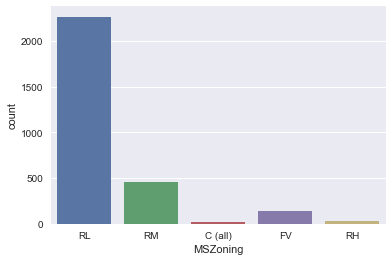

In [30]:
g = sns.countplot(dataset["MSZoning"])
dataset["MSZoning"] = dataset["MSZoning"].fillna("RL")

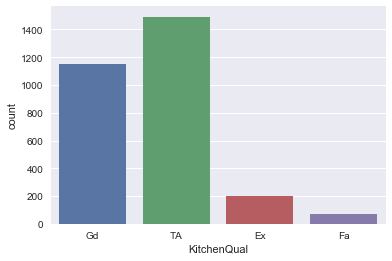

In [31]:
# 1개의 결측값 처리
g = sns.countplot(dataset["KitchenQual"])
dataset["KitchenQual"] = dataset["KitchenQual"].fillna("TA")

In [32]:
## 결측값 갯수.
# GarageArea         1
# GarageCars         1
# GarageCond       159
# GarageFinish     159
# GarageQual       159
# GarageType       157
# GarageYrBlt      159 >> YearBuilt??
dataset["GarageCond"] = dataset["GarageCond"].fillna("No")
dataset["GarageFinish"] = dataset["GarageFinish"].fillna("No")
dataset["GarageQual"] = dataset["GarageQual"].fillna("No")
dataset["GarageType"] = dataset["GarageType"].fillna("No")

dataset.loc[dataset["GarageType"] == "No", "GarageYrBlt"] = dataset["YearBuilt"]
[dataset["GarageType"]=="No"]
dataset.loc[dataset["GarageType"]=="No", "GarageCars"] = 0
dataset.loc[dataset["GarageType"]=="No", "GarageArea"] = 0
dataset["GarageArea"] = dataset["GarageArea"].fillna(dataset["GarageArea"].median())
dataset["GarageCars"] = dataset["GarageCars"].fillna(dataset["GarageCars"].median())
dataset["GarageYrBlt"] = dataset["GarageYrBlt"].fillna(dataset["YearBuilt"])

[0       False
 1       False
 2       False
 3       False
 4       False
 5       False
 6       False
 7       False
 8       False
 9       False
 10      False
 11      False
 12      False
 13      False
 14      False
 15      False
 16      False
 17      False
 18      False
 19      False
 20      False
 21      False
 22      False
 23      False
 24      False
 25      False
 26      False
 27      False
 28      False
 29      False
         ...  
 2887    False
 2888    False
 2889     True
 2890     True
 2891     True
 2892    False
 2893    False
 2894    False
 2895    False
 2896    False
 2897    False
 2898    False
 2899    False
 2900    False
 2901    False
 2902    False
 2903    False
 2904    False
 2905    False
 2906    False
 2907     True
 2908    False
 2909    False
 2910    False
 2911     True
 2912     True
 2913    False
 2914    False
 2915     True
 2916    False
 Name: GarageType, Length: 2917, dtype: bool]

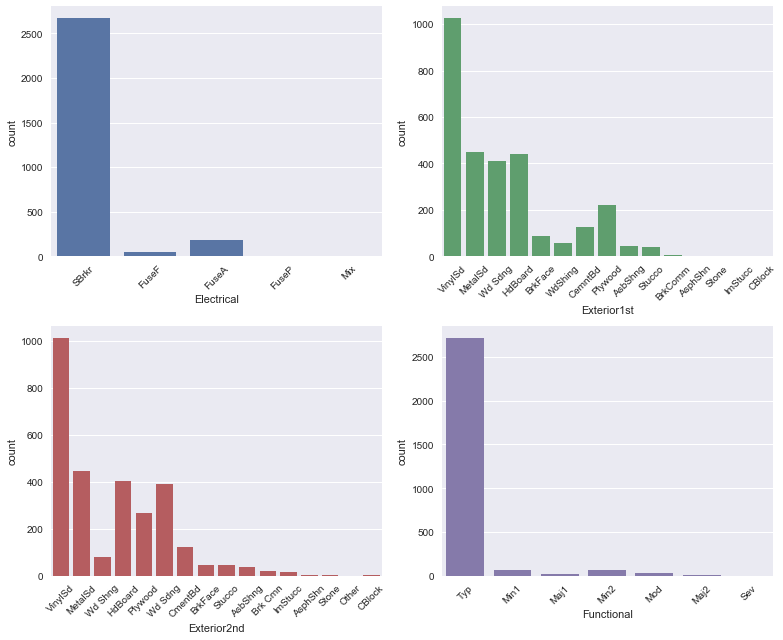

In [33]:
# Electrical         1
# Exterior1st        1
# Exterior2nd        1
# Functional         2
function_feat = ["Electrical","Exterior1st","Exterior2nd","Functional"]
multiplot(data=dataset, features=function_feat, plottype="countplot"
          ,nrows=2,ncols=2, figsize=(11,9), colorize=True)
# 처리: 많은 값으로
dataset["Electrical"] = dataset["Electrical"].fillna("SBrkr")
dataset["Exterior1st"] = dataset["Exterior1st"].fillna("VinySd")
dataset["Exterior2nd"] = dataset["Exterior2nd"].fillna("VinylSd")
dataset["Functional"] = dataset["Functional"].fillna("Typ")


In [34]:
## 결측값 처리 
# MasVnrArea        23
# MasVnrType        24
dataset["MasVnrType"] = dataset["MasVnrType"].fillna("None")
dataset.loc[dataset["MasVnrType"]=="None", "MasVnrArea"] = 0

## 4. feature 변환/엔지니어링
- 4.1: 범주형 변수(Categorical values)
- 4.2: 숫자형 변수(Numerical Values)
- 4.3: Normalization
- 4.4: Missing LotFrontage prediction

### 4.1: 범주형 변수(Categorical values)
- MSSubClass : 숫자형 변수가 아닌 범주형 변수 (class 숫자)
- MoSold : 월도 
- YrSold : 년도

In [35]:
# MSSubClass : 숫자형 변수 > 범주형 변수로 변환
# dataset['MSSubClass']
dataset = dataset.replace({'MSSubClass':{20: 'SubClass_20', 30: 'SubClass_30', 40: 'SubClass_40'
                                        , 45: 'SubClass_45', 50: 'SubClass_50', 60: 'SubClass_60'
                                        , 70: 'SubClass_70', 80: 'SubClass_80', 85: 'SubClass_85'
                                        , 90: 'SubClass_90', 120: 'SubClass_120', 150: 'SubClass_150'
                                        , 160: 'SubClass_160', 180: 'SubClass_180', 190: 'SubClass_190'
                                        }})
# dataset['MSSubClass']

In [36]:
# MoSold : 월도 변환
dataset = dataset.replace({'MoSold':{1: 'Jan', 2: 'Feb', 3: 'Mar'
                                    ,4: 'Apr', 5: 'May', 6: 'Jun'
                                    ,7: 'Jul', 8: 'Aug', 9: 'Sep'
                                    ,10: 'Oct', 11: 'Nov', 12: 'Dec'}})

In [37]:
# YrSold : 년도 타입 변환(숫자 > 문자)
dataset['YrSold'] = dataset['YrSold'].astype(str)
# dataset['YrSold']

In [38]:
# dataset["SalePrice"].groupby(dataset['Neighborhood']).median().sort_values()
neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
}
dataset["NeighborhoodBin"] = dataset["Neighborhood"].map(neighborhood_map)

In [39]:
## order category
dataset["BsmtCond"] = dataset["BsmtCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["BsmtExposure"] = dataset["BsmtExposure"].astype("category",categories=['No','Mn','Av','Gd'],ordered=True).cat.codes
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
dataset["BsmtQual"] = dataset["BsmtQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["ExterCond"] = dataset["ExterCond"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["ExterQual"] = dataset["ExterQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Fence"] = dataset["Fence"].astype("category",categories=['No','MnWw','GdWo','MnPrv','GdPrv'],ordered=True).cat.codes
dataset["FireplaceQu"] = dataset["FireplaceQu"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Functional"] = dataset["Functional"].astype("category",categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],ordered=True).cat.codes
dataset["GarageCond"] = dataset["GarageCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["GarageFinish"] = dataset["GarageFinish"].astype("category",categories=['No','Unf','RFn','Fin'],ordered=True).cat.codes
dataset["GarageQual"] = dataset["GarageQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["HeatingQC"] = dataset["HeatingQC"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["KitchenQual"] = dataset["KitchenQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["PavedDrive"] = dataset["PavedDrive"].astype("category",categories=['N','P','Y'],ordered=True).cat.codes
dataset["PoolQC"] = dataset["PoolQC"].astype("category",categories=['No','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Utilities"] = dataset["Utilities"].astype("category",categories=['ELO','NoSeWa','NoSewr','AllPub'],ordered=True).cat.codes

In [40]:
## Nonordered : 공분산에 영향을 미치는 변수들
# non ordered
dataset = pd.get_dummies(dataset,columns=["Alley","BldgType","CentralAir",
"Condition1","Condition2","Electrical","Exterior1st","Exterior2nd","Foundation",
"GarageType","Heating","HouseStyle","LandContour","LandSlope","LotConfig","LotShape",
"MSZoning","MasVnrType","MiscFeature","Neighborhood","RoofMatl","RoofStyle",
"SaleCondition","SaleType","Street","MSSubClass",'MoSold','YrSold'],drop_first=True)

### 4.2: 숫자형 변수

In [41]:
# 왜도 줄이기(log 변환)
skewed_features = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","GarageArea","MasVnrArea"
                   ,"TotalBsmtSF","1stFlrSF","2ndFlrSF","3SsnPorch","EnclosedPorch",
                   "GrLivArea","LotArea","LowQualFinSF","OpenPorchSF","PoolArea",
                   "ScreenPorch","WoodDeckSF"]

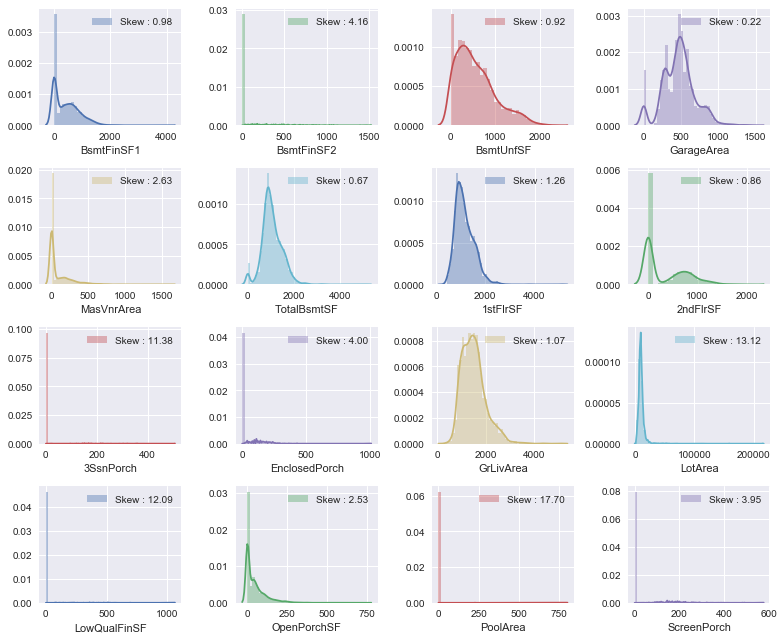

In [42]:
multiplot(data = dataset,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

In [43]:
for feature in skewed_features:
    dataset[feature] = np.log1p(dataset[feature])

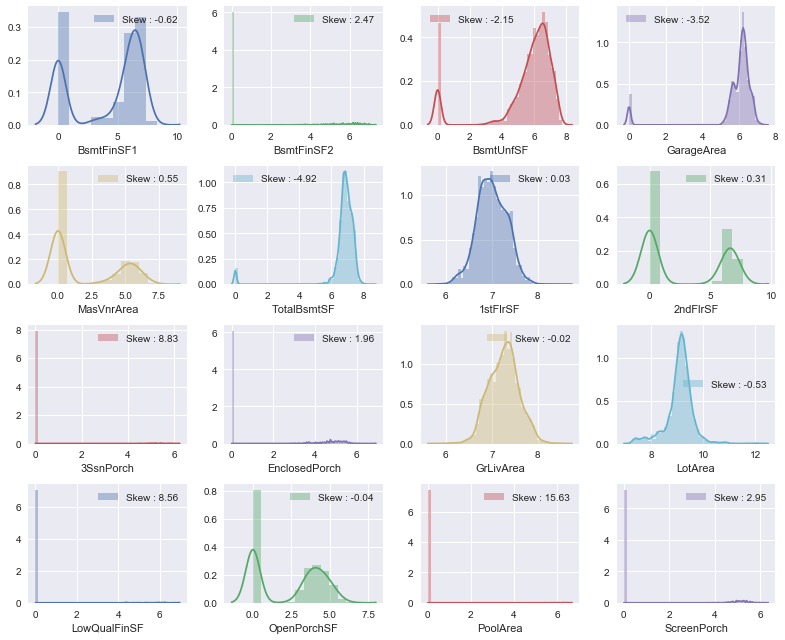

In [44]:
multiplot(data = dataset,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

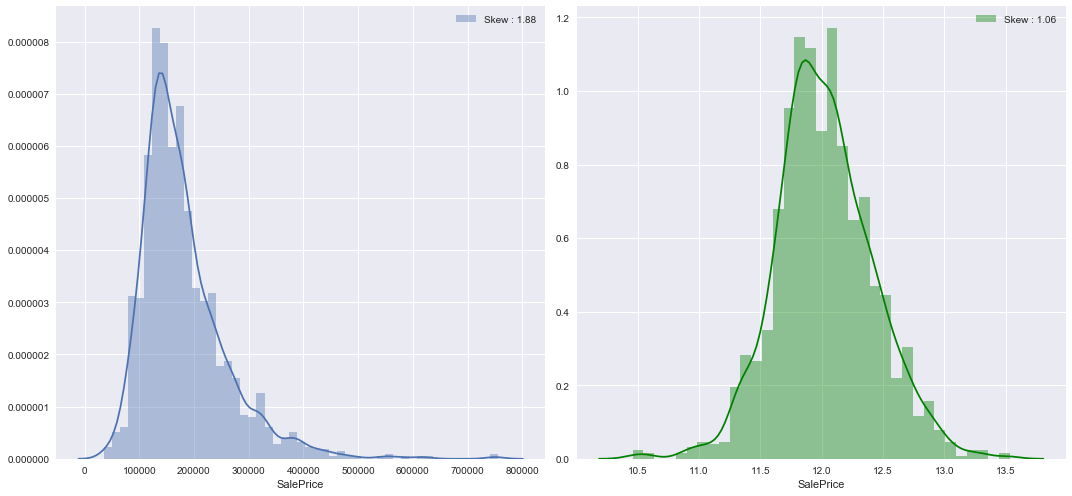

In [45]:
# y값 결과변수 : SalePrice 의 로그변환
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(df_train["SalePrice"],ax = axes[0])
sns.distplot(np.log1p(df_train["SalePrice"]),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(df_train["SalePrice"].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(df_train["SalePrice"].skew()))])

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [46]:
dataset['SalePrice'] = np.log1p(dataset['SalePrice'])
Y = dataset["SalePrice"]
dataset = dataset.drop(labels="SalePrice", axis=1)

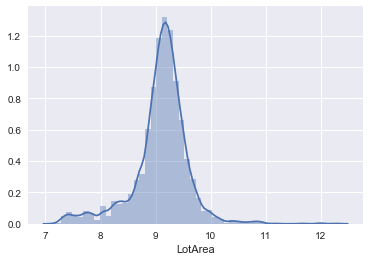

In [47]:
g = sns.distplot(dataset['LotArea'])

In [48]:
dataset['LotFrontage']

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
5        85.0
6        75.0
7         NaN
8        51.0
9        50.0
10       70.0
11       85.0
12        NaN
13       91.0
14        NaN
15       51.0
16        NaN
17       72.0
18       66.0
19       70.0
20      101.0
21       57.0
22       75.0
23       44.0
24        NaN
25      110.0
26       60.0
27       98.0
28       47.0
29       60.0
        ...  
2887     50.0
2888     75.0
2889     69.0
2890     50.0
2891     60.0
2892     41.0
2893     44.0
2894     69.0
2895     65.0
2896     70.0
2897    140.0
2898      NaN
2899      NaN
2900     95.0
2901     88.0
2902    125.0
2903     78.0
2904     41.0
2905     58.0
2906      NaN
2907     21.0
2908     21.0
2909     80.0
2910     21.0
2911     21.0
2912     21.0
2913     21.0
2914    160.0
2915     62.0
2916     74.0
Name: LotFrontage, Length: 2917, dtype: float64

### 4.2: Normalization

In [49]:
features = dataset.columns

LotF = dataset["LotFrontage"]
dataset = dataset.drop(labels="LotFrontage",axis= 1)

In [50]:
# Normalize Data
# N = Normalizer()
N = RobustScaler() # >> 이상값 최적제거.

N.fit(dataset)
dataset = N.transform(dataset)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

## 5. 모델링
- 5.1: Linear Regression models
- 5.2: Tree base Modeling
- 5.3: Stacking Model

### 5.1: Simple Modeling : Lasso, Ridge, Elasticnet

In [85]:
# train, test 데이터 나누기.
X_train = dataset[:df_train_len]
test = dataset[df_train_len:]

In [86]:
# train_y 값 분류
Y_train = Y[:df_train_len]

In [87]:
# 각 모델수행
lassocv = LassoCV(eps=1e-8)
ridge = Ridge(alpha=1e-7)
lassolarcv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

#### 5.1.1 : Cross Validate Models : 교차검증

#### Base Model만!

In [90]:
# 1.
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=kf,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [91]:
# 1.
RMSE(lassocv, X_train, Y_train)

0.11458039397213601

In [92]:
RMSE(ridge, X_train, Y_train)

0.12691540294924661

In [93]:
RMSE(lassolarcv, X_train, Y_train)

0.11542923464001975

In [94]:
RMSE(elasticnetcv, X_train, Y_train)

0.11471781842792325

In [95]:
lassocv.fit(X_train, Y_train)
ridge.fit(X_train, Y_train)
lassolarcv.fit(X_train, Y_train)
elasticnetcv.fit(X_train, Y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=1e-08, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

Ridge(alpha=1e-07, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

LassoLarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

#### 5.1.2 : Feature coefficients

In [96]:
lasso_coef = pd.Series(lassocv.coef_)
ridge_coef = pd.Series(ridge.coef_)
lassolar_coef = pd.Series(lassolarcv.coef_)
elastic_coef = pd.Series(elasticnetcv.coef_)

print("LaossCV : 전체변수 "+str(X_train.shape[1])+ "개 중, "+str(sum(lasso_coef !=0))+"개 변수선택")
print("Ridge : 전체변수 "+str(X_train.shape[1])+ "개 중, "+str(sum(ridge_coef !=0))+"개 변수선택")
print("LaossLarCV : 전체변수 "+str(X_train.shape[1])+ "개 중, "+str(sum(lassolar_coef !=0))+"개 변수선택")
print("ElasticCV : 전체변수 "+str(X_train.shape[1])+ "개 중, "+str(sum(elastic_coef !=0))+"개 변수선택")

LaossCV : 전체변수 232개 중, 62개 변수선택
Ridge : 전체변수 232개 중, 230개 변수선택
LaossLarCV : 전체변수 232개 중, 63개 변수선택
ElasticCV : 전체변수 232개 중, 70개 변수선택


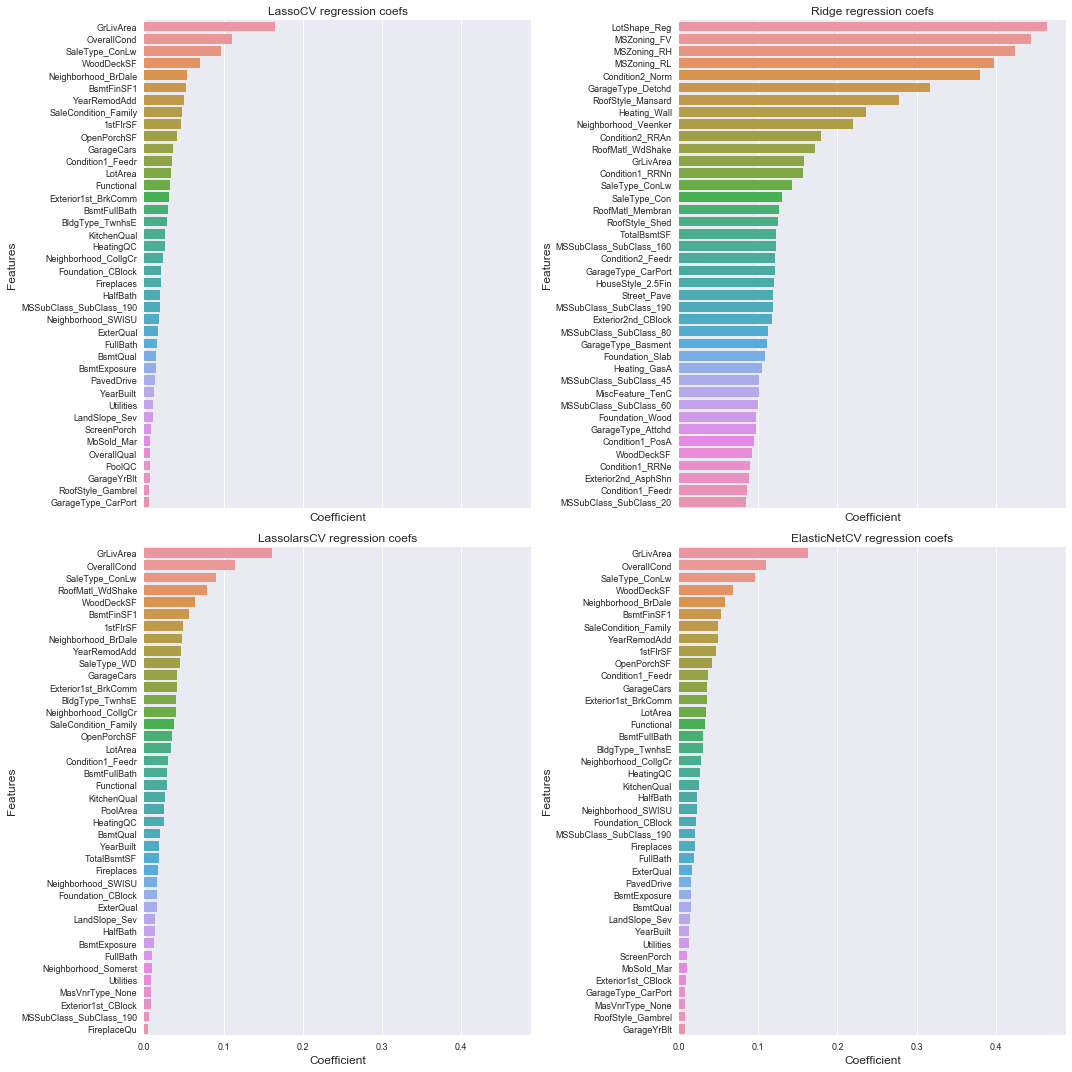

In [97]:
# 변수의 중요도
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("LassoCV", lassocv),("Ridge",ridge),("LassolarsCV",lassolarcv),("ElasticNetCV",elasticnetcv)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.coef_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.coef_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Coefficient",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " regression coefs")
        nregressors += 1
plt.tight_layout()
plt.show()
plt.gcf().clear()

- 4 model 모두 GriLivArea 변수가 제일 중요

In [98]:
# 결과값 예측결과 수행 : rmse가 높은 ridge는 제외
Y_pred_lassocv = np.expm1(lassocv.predict(test))
Y_pred_lassolarcv = np.expm1(lassolarcv.predict(test))
Y_pred_elasticnetcv = np.expm1(elasticnetcv.predict(test))

In [99]:
# combine predictions model : 제출 1 
output_path = "./submit/Submit1_20171027(neighborhoodbin추가).csv" 
pred = (Y_pred_lassocv*0.4 + Y_pred_lassolarcv*0.3 + Y_pred_elasticnetcv*0.3)
solution = pd.DataFrame({"SalePrice":pred,"Id": origin_test.Id})
solution.to_csv(output_path, index=False)

![](./image/singlemodel_20171027.png)

### 5.2: Tree based modeling : CatBoost, Lightgbm, Gredient Boosting

In [100]:
# Gredient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=4,max_features='sqrt',
                                  min_samples_leaf=15,min_samples_split=10,
                                  loss='huber', random_state=5)
RMSE(GBoost, X_train, Y_train)

0.11620487581336805

In [101]:
# Light GBM
LightGB = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                           learning_rate=0.05,n_estimators=720,
                           max_bin=55, bagging_fraction=0.8,
                           feature_fraction_seed=9, bagging_seed=9,
                           min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
RMSE(LightGB, X_train, Y_train)

0.11612296334457413

In [102]:
# Catboost
Catbst = cat.CatBoostRegressor(learning_rate=0.05, depth=6, loss_function='RMSE',
                              iterations=720,l2_leaf_reg=6,rsm=1,feature_border_type='MinEntropy')
RMSE(Catbst, X_train, Y_train)

0.22182077214830592

In [131]:
GBoost.fit(X_train, Y_train)
Y_pred_GBoost = np.expm1(GBoost.predict(test))
LightGB.fit(X_train, Y_train)
Y_pred_LightGB = np.expm1(LightGB.predict(test))
Catbst.fit(X_train, Y_train)
Y_pred_Catbst = np.expm1(Catbst.predict(test))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=5,
             subsample=1.0, verbose=0, warm_start=False)

LGBMRegressor(bagging_fraction=0.8, bagging_seed=9, boosting_type='gbdt',
       colsample_bytree=1.0, feature_fraction_seed=9, learning_rate=0.05,
       max_bin=55, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_data_in_leaf=6, min_split_gain=0.0, min_sum_hessian_in_leaf=11,
       n_estimators=720, n_jobs=-1, num_leaves=5, objective='regression',
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

#### Features Importance

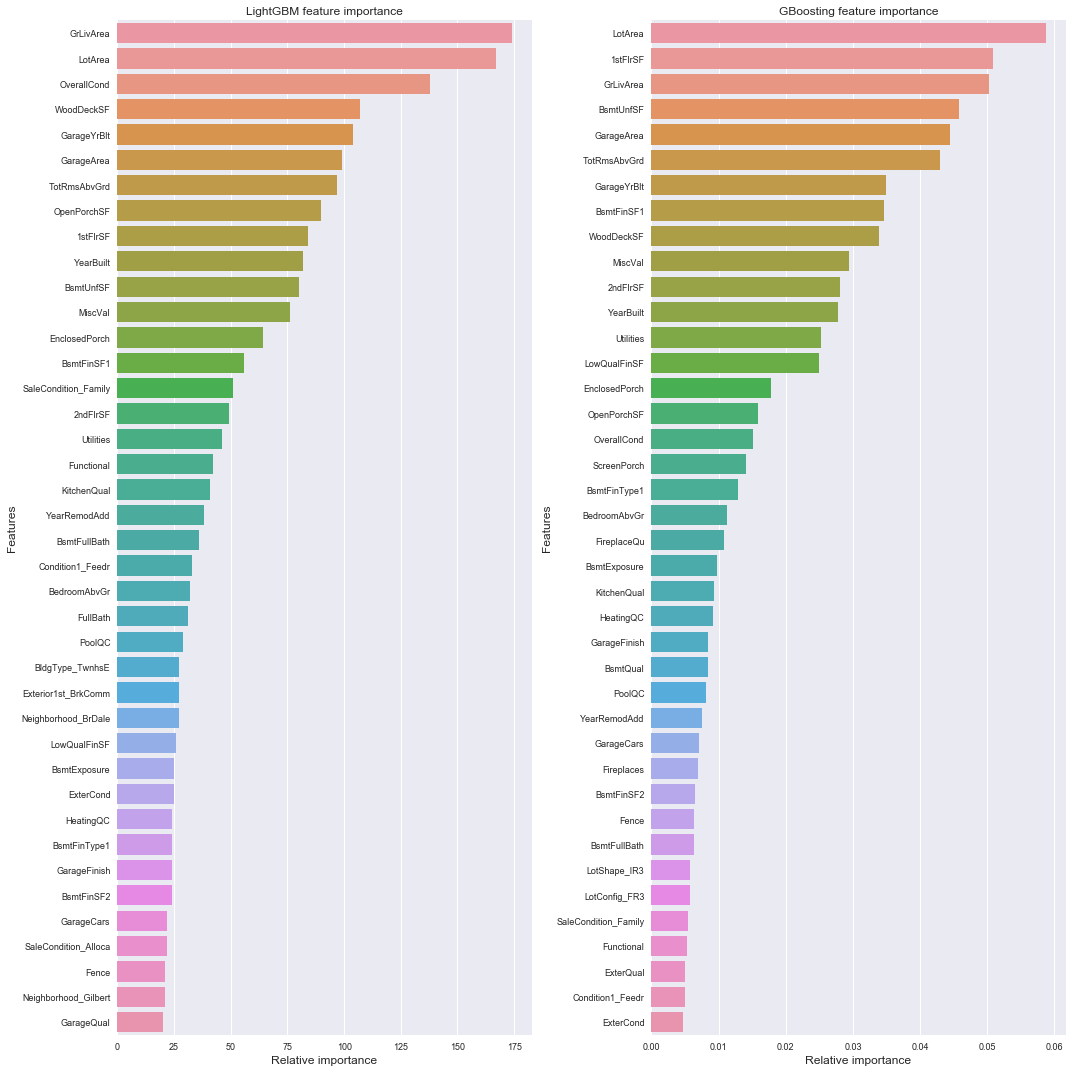

In [105]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,15))

names_regressors = [("LightGBM",LightGB),("GBoosting",GBoost)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.feature_importances_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.feature_importances_[indices][:40] , orient='h',ax=axes[nregressors])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nregressors += 1

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [104]:
# combine predictions model : 제출 2 >> 
output_path = "./submit/Submit2_20171027(Tree_model(이웃값추가최종)).csv" 
pred = (Y_pred_lassocv*0.4 + Y_pred_lassolarcv*0.3 + Y_pred_elasticnetcv*0.3)*0.8+Y_pred_GBoost*0.1+Y_pred_LightGB*0.1
solution = pd.DataFrame({"SalePrice":pred,"Id": origin_test.Id})
solution.to_csv(output_path, index=False)

![](./image/treemodel_20171027.png)

### 5.3 : Stacking Model

In [107]:
# 2. Validation function : 'Cross_val_score' 를 썼음
n_folds = 5
def RMSE_CV(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### 5.3.1 Basic model

In [108]:
# LassoCV 
lasso = make_pipeline(RobustScaler(), lassocv)
lasso_score = RMSE_CV(lasso)
print("Lasso score : {:.4f}".format(lasso_score.mean()))

Lasso score : 0.1147


In [110]:
# Kernal Ridge Regression
krrRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
krr = make_pipeline(RobustScaler(), krrRR)
krr_score = RMSE_CV(krr)
print("KRR score : {:.4f}".format(krr_score.mean()))

KRR score : 0.4889


In [111]:
# Elastic net
Enet = make_pipeline(RobustScaler(), elasticnetcv)
Enet_score = RMSE_CV(Enet)
print("Enet : {:.4f}".format(Enet_score.mean()))

Enet : 0.1147


In [112]:
# Gradient Boosting Regression
GBoostRE = make_pipeline(RobustScaler(), GBoost)
GBoost_score = RMSE_CV(GBoostRE)
print("GBoost : {:.4f}".format(GBoost_score.mean()))

GBoost : 0.1162


In [113]:
# LightGBM
LightGB_model = make_pipeline(RobustScaler(), LightGB)
LightGB_score = RMSE_CV(LightGB_model)
print("LightGB : {:.4f}".format(LightGB_score.mean()))

LightGB : 0.1157


#### Averaging Model

In [114]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [116]:
averaged_models = AveragingModels(models=(lasso, Enet, GBoostRE, LightGB_model))
score = RMSE_CV(averaged_models)
print("Averaged base models score : {:.4f}".format(score.mean()))

Averaged base models score : 0.1097


#### 덜 단순한 Stacking : Adding a Meta-model 
: 평균기반모델에 메타모델을 추가하여 기본 모델 예측을 사용하여 메타모델을 교육
1. 전체 training data를 train/hold out 두 세트로 분리 
2. 1의 기본 train세트에 여러 기본 모델을 수행.
3. 기본 모델을 테스트(hold out)
4. 3에서 테스트한 기본 모델들의 예측값을 테스트 값과 비교.

![](./image/less meta-model stacking.jpg)

In [123]:
# Stacking averaged Models Class
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [126]:
stacked_averaged_models = StackingAveragedModels(base_models = (Enet, GBoostRE),
                                                 meta_model = lasso)

score = RMSE_CV(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean()))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### Final Prediction

In [127]:
# StackingRegressor
stacked_averaged_models.fit(X_train, Y_train)
stacked_train_pred=stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(test))

StackingAveragedModels(base_models=(Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnetcv', ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs...s=3000, presort='auto', random_state=5,
             subsample=1.0, verbose=0, warm_start=False))])),
            meta_model=Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lassocv', LassoCV(alphas=None, copy_X=True, cv=None, eps=1e-08, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))]),
            n_folds=5)

In [128]:
# LightGBM
LightGB.fit(X_train,Y_train) 
log_train_pred= LightGB.predict(X_train)
lgb_pred = np.expm1(LightGB.predict(test))

LGBMRegressor(bagging_fraction=0.8, bagging_seed=9, boosting_type='gbdt',
       colsample_bytree=1.0, feature_fraction_seed=9, learning_rate=0.05,
       max_bin=55, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_data_in_leaf=6, min_split_gain=0.0, min_sum_hessian_in_leaf=11,
       n_estimators=720, n_jobs=-1, num_leaves=5, objective='regression',
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

In [129]:
# combine predictions model : 제출 3
output_path = "./submit/Submit3_20171027(stacking model).csv" 
pred = (stacked_pred*0.8 + lgb_pred*0.2)
solution = pd.DataFrame({"SalePrice":pred,"Id": origin_test.Id})
solution.to_csv(output_path, index=False)

![](./image/stacking_score.PNG)

# 느낀점

- 데이터 전처리의 중요성 인식: 커널들을 많이 보면서 전처리 방법을 습득.
- 기본 Regression 모델들의 사용법을 공부하고 어떨때 쓰는지 공부됨.
: Lasso, Ridge, LightGBM, XGBoost
- 모델을 Stacking하는 방법을 더 연구하고 봐야 할듯함.

## 참조커널
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/yassineghouzam/eda-introduction-to-ensemble-regression